Ex.1: Smart Home Energy and Comfort System

Is model OK? -> True


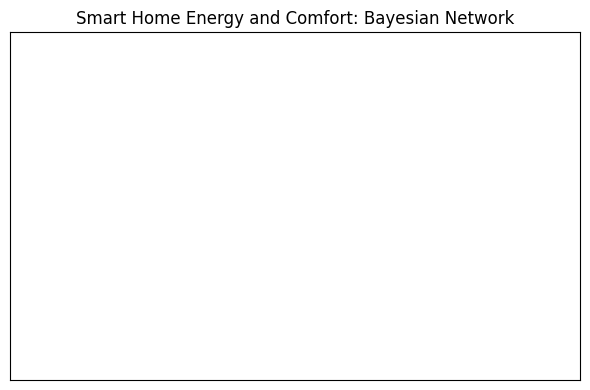


P(H|C=comfortable):
+--------+----------+
| H      |   phi(H) |
+========+==========+
| H(yes) |   0.4823 |
+--------+----------+
| H(no)  |   0.5177 |
+--------+----------+
Numerical P(H=yes|C=comfortable) = 0.48226326141694925

P(E | C = comfortable):
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.4894 |
+---------+----------+
| E(low)  |   0.5106 |
+---------+----------+
Numerical P(E = high | C = comfortable) = 0.4893579568501696

MAP(H, W | C = comfortable): {'W': 'no', 'H': 'yes'}

Is W independent of E given H? True
Are O and C independent given R? True


In [6]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

#a)
model = DiscreteBayesianNetwork([
    ("O", "H"),
    ("O", "W"),
    ("H", "R"),
    ("W", "R"),
    ("H", "E"),
    ("R", "C"),
])

cpd_O = TabularCPD(
    variable="O",
    variable_card=2,
    values=[[0.3], [0.7]],
    state_names={"O": ["cold", "mild"]}
)

cpd_H = TabularCPD(
    variable="H",
    variable_card=2,
    values=[
        [0.9, 0.2],
        [0.1, 0.8],
    ],
    evidence=["O"],
    evidence_card=[2],
    state_names={
        "H": ["yes", "no"],
        "O": ["cold", "mild"],
    }
)

cpd_W = TabularCPD(
    variable="W",
    variable_card=2,
    values=[
        [0.1, 0.6],
        [0.9, 0.4],
    ],
    evidence=["O"],
    evidence_card=[2],
    state_names={
        "W": ["yes", "no"],
        "O": ["cold", "mild"],
    }
)

cpd_R = TabularCPD(
    variable="R",
    variable_card=2,
    values=[
        [0.6, 0.9, 0.3, 0.5],
        [0.4, 0.1, 0.7, 0.5],
    ],
    evidence=["H", "W"],
    evidence_card=[2, 2],
    state_names={
        "R": ["warm", "cool"],
        "H": ["yes", "no"],
        "W": ["yes", "no"],
    }
)

cpd_E = TabularCPD(
    variable="E",
    variable_card=2,
    values=[
        [0.8, 0.2],
        [0.2, 0.8],
    ],
    evidence=["H"],
    evidence_card=[2],
    state_names={
        "E": ["high", "low"],
        "H": ["yes", "no"],
    }
)

cpd_C = TabularCPD(
    variable="C",
    variable_card=2,
    values=[
        [0.85, 0.40],
        [0.15, 0.60],
    ],
    evidence=["R"],
    evidence_card=[2],
    state_names={
        "C": ["comfortable", "uncomfortable"],
        "R": ["warm", "cool"],
    }
)

#adaugam toate CPD-urile in model
model.add_cpds(cpd_O, cpd_H, cpd_W, cpd_R, cpd_E, cpd_C)

print("Is model OK? ->", model.check_model())

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(model)
nx.draw_networkx(model, pos, with_labels=True, arrows=False)
plt.title("Smart Home Energy and Comfort: Bayesian Network")
plt.tight_layout()
plt.show() #asta n-a mers deloc ca nu arata nimica

#b)
inference = VariableElimination(model)

q_H = inference.query(
    variables=["H"],
    evidence={"C": "comfortable"},
    show_progress=False
)
print("\nP(H|C=comfortable):")
print(q_H)
print("Numerical P(H=yes|C=comfortable) =",
      float(q_H.values[q_H.state_names['H'].index('yes')]))

q_E = inference.query(
    variables=["E"],
    evidence={"C": "comfortable"},
    show_progress=False
)
print("\nP(E | C = comfortable):")
print(q_E)
print("Numerical P(E = high | C = comfortable) =",
      float(q_E.values[q_E.state_names['E'].index('high')]))

map_HW = inference.map_query(
    variables=["H", "W"],
    evidence={"C": "comfortable"},
    show_progress=False
)
print("\nMAP(H, W | C = comfortable):", map_HW)

#c)
ind_WE_given_H = not model.is_dconnected("W", "E", observed=["H"])
print("\nIs W independent of E given H?", ind_WE_given_H)

ind_OC_given_R = not model.is_dconnected("O", "C", observed=["R"])
print("Are O and C independent given R?", ind_OC_given_R)


Ex.2: Weather and Activity Prediction using HMM

In [8]:
import numpy as np
import random

#a)

#hidden states and observations
states = ["W", "R", "S"]          #Walking, Running, Resting
observations = ["L", "M", "H"]    #Low, Medium, High

state_index = {s: i for i, s in enumerate(states)}
obs_index = {o: i for i, o in enumerate(observations)}

#initial state probabilities π
pi = np.array([0.4, 0.3, 0.3])     #[P(W), P(R), P(S)]

#transition matrix
A = np.array([
    [0.6, 0.3, 0.1],
    [0.2, 0.7, 0.1],
    [0.3, 0.2, 0.5]
])

B = np.array([
    [0.1, 0.7, 0.2],
    [0.05, 0.25, 0.7],
    [0.8, 0.15, 0.05]
])

obs_seq_labels = ["M", "H", "L"]
O = [obs_index[o] for o in obs_seq_labels]   #numerical indices

#b)

def forward(pi, A, B, O):
    N = len(pi)
    T = len(O)
    alpha = np.zeros((T, N))

    #initialization
    alpha[0, :] = pi * B[:, O[0]]

    #recursion
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = B[j, O[t]] * np.sum(alpha[t - 1, :] * A[:, j])

    #termination
    prob = np.sum(alpha[T - 1, :])
    return alpha, prob


alpha, prob_forward = forward(pi, A, B, O)
print("P([M,H,L]) by Forward algorithm =", prob_forward)

#c)

def viterbi(pi, A, B, O):
    N = len(pi)
    T = len(O)
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)

    #initialization
    delta[0, :] = pi * B[:, O[0]]
    psi[0, :] = 0

    #recursion
    for t in range(1, T):
        for j in range(N):
            probs = delta[t - 1, :] * A[:, j]
            psi[t, j] = np.argmax(probs)
            delta[t, j] = B[j, O[t]] * np.max(probs)

    #bkt
    path = np.zeros(T, dtype=int)
    path[T - 1] = np.argmax(delta[T - 1, :])
    for t in range(T - 2, -1, -1):
        path[t] = psi[t + 1, path[t + 1]]

    best_prob = np.max(delta[T - 1, :])
    return path, best_prob


best_path_idx, best_path_prob = viterbi(pi, A, B, O)
best_path_labels = [states[i] for i in best_path_idx]

print("Most likely hidden states for [M,H,L]:", best_path_labels)
print("Probability of this path (Viterbi):", best_path_prob)

print("\nWhy Viterbi instead of brute force for long sequences?")
print("Because Viterbi is O(N^2 * T) while brute force is O(N^T).")
print("For long T, N^T explodes and becomes infeasible, but Viterbi stays polynomial.")

#d)

def sample_from_distribution(probs):
    r = random.random()
    cum = 0.0
    for i, p in enumerate(probs):
        cum += p
        if r <= cum:
            return i
    return len(probs) - 1  #fallback due to floating point

def generate_sequence(pi, A, B, T):
    N = len(pi)
    states_seq = []
    obs_seq = []

    #initial state
    s = sample_from_distribution(pi)
    states_seq.append(s)
    obs_seq.append(sample_from_distribution(B[s, :]))

    #next steps
    for _ in range(1, T):
        s = sample_from_distribution(A[s, :])
        states_seq.append(s)
        obs_seq.append(sample_from_distribution(B[s, :]))

    return states_seq, obs_seq

T = len(O)
num_samples = 10000
count = 0

for _ in range(num_samples):
    _, obs_sample = generate_sequence(pi, A, B, T)
    if obs_sample == O:
        count += 1

empirical_prob = count / num_samples

print("\nEmpirical P([M,H,L]) from", num_samples, "samples =", empirical_prob)
print("Exact P([M,H,L]) from Forward algorithm    =", prob_forward)


P([M,H,L]) by Forward algorithm = 0.021117249999999997
Most likely hidden states for [M,H,L]: ['W', 'R', 'S']
Probability of this path (Viterbi)   : 0.004704

Why Viterbi instead of brute force for long sequences?
Because Viterbi is O(N^2 * T) while brute force is O(N^T).
For long T, N^T explodes and becomes infeasible, but Viterbi stays polynomial.

Empirical P([M,H,L]) from 10000 samples = 0.0231
Exact P([M,H,L]) from Forward algorithm    = 0.021117249999999997
